In [1]:
# Script to evaluate a certain pix2pix hyperparameter

import argparse
import os
import random
from ssim.utils import get_gaussian_kernel
import cv2
from ssim import SSIM
from PIL import Image
from utils_stereofog import calculate_model_results, variance_of_laplacian, image_mse, image_ncc, structural_similarity

from general_imports import *

In [2]:
results_paths = ['results/final_models/stereofog_pix2pix',
                 'results/final_models/stereofog_pix2pix_augmented',
                'results/synthetic_datasets/carla_tuebingen_pix2pix',
                'results/synthetic_datasets/cityscapes_tuebingen_pix2pix',
                'results/synthetic_datasets/foggy_cityscapes_pix2pix']

In [3]:
all_laplace_scores = []
all_Pearson_correlation_scores = []
all_MSE_scores = []
all_NCC_scores = []
all_SSIM_scores = []
all_CW_SSIM_scores = []

for results_path in results_paths:
    # Part that needs to be inserted due to the way pix2pix saves the images
    subpath_addition = 'test_latest/images'

    if subpath_addition not in results_path:
        results_path = os.path.join(results_path, f'test_latest/images')


    images = [item for item in os.listdir(results_path) if 'fake_B' in item]


    # ax = [fig.add_subplot(num_models+2,limit,i+1) for i in range(limit*(num_models+2))]

    # ax[0].text(0.5, 1.05, 'fake', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[0].transAxes)
    # ax[1].text(0.5, 1.05, 'foggy real', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[1].transAxes)
    # ax[2].text(0.5, 1.05, 'clear real', fontsize=15, color='k', fontweight='black', ha='center', transform=ax[2].transAxes)

    # CW-SSIM implementation
    gaussian_kernel_sigma = 1.5
    gaussian_kernel_width = 11
    gaussian_kernel_1d = get_gaussian_kernel(gaussian_kernel_width, gaussian_kernel_sigma)

    # Indexing the images
    images = [entry for entry in os.listdir((results_path)) if 'fake_B' in entry]

    laplace_scores = []
    Pearson_correlation_scores = []
    MSE_scores = []
    NCC_scores = []
    SSIM_scores = []
    CW_SSIM_scores = []

    for i, image in enumerate(images):

        fogged_image_gray = cv2.cvtColor(cv2.imread(os.path.join(results_path, image[:-10] + 'real_A' + '.png')), cv2.COLOR_BGR2GRAY)
        
        laplace_scores.append(variance_of_laplacian(fogged_image_gray))

        clear_image_nonfloat = cv2.imread(os.path.join(results_path, images[i][:-10] + 'real_B' + '.png'))
        fogged_image_nonfloat = cv2.imread(os.path.join(results_path, images[i][:-10] + 'real_A' + '.png'))
        fake_image_nonfloat = cv2.imread(os.path.join(results_path, images[i]))

        # Calculating the Pearson correlation coefficient between the two images (https://stackoverflow.com/questions/34762661/percentage-difference-between-two-images-in-python-using-correlation-coefficient, https://mbrow20.github.io/mvbrow20.github.io/PearsonCorrelationPixelAnalysis.html)
        clear_image_gray = cv2.cvtColor(clear_image_nonfloat, cv2.COLOR_BGR2GRAY)
        fake_image_gray = cv2.cvtColor(fake_image_nonfloat, cv2.COLOR_BGR2GRAY)
        Pearson_image_correlation = np.corrcoef(np.asarray(fake_image_gray), np.asarray(clear_image_gray))
        corrImAbs = np.absolute(Pearson_image_correlation)

        Pearson_correlation_scores.append(np.mean(corrImAbs))

        # Calculating the MSE between the two images
        MSE_score = image_mse(clear_image_gray, fake_image_gray)
        MSE_scores.append(MSE_score)

        # Calculating the NCC between the two images
        NCC_score = image_ncc(clear_image_gray, fake_image_gray)
        NCC_scores.append(NCC_score)

        # Calculating the SSIM between the fake image and the clear image
        (SSIM_score_reconstruction, SSIM_diff_reconstruction) = structural_similarity(clear_image_nonfloat, fogged_image_nonfloat, full=True, multichannel=True, channel_axis=2)
        SSIM_scores.append(SSIM_score_reconstruction)

        # Calculating the CW-SSIM between the fake image and the clear image (https://github.com/jterrace/pyssim)
        CW_SSIM = SSIM(Image.open(os.path.join(results_path, images[i][:-10] + 'real_B' + '.png'))).cw_ssim_value(Image.open(os.path.join(results_path, images[i])))
        CW_SSIM_scores.append(CW_SSIM)

    # Calculate the average values
    mean_laplace = np.mean(laplace_scores)
    mean_Pearson = np.mean(Pearson_correlation_scores)
    mean_MSE = np.mean(MSE_scores)
    mean_NCC = np.mean(NCC_scores)
    mean_SSIM = np.mean(SSIM_scores)
    mean_CW_SSIM = np.mean(CW_SSIM_scores)

    all_laplace_scores += [laplace_scores]
    all_Pearson_correlation_scores += [Pearson_correlation_scores]
    all_MSE_scores += [MSE_scores]
    all_NCC_scores += [NCC_scores]
    all_SSIM_scores += [SSIM_scores]
    all_CW_SSIM_scores += [CW_SSIM_scores]

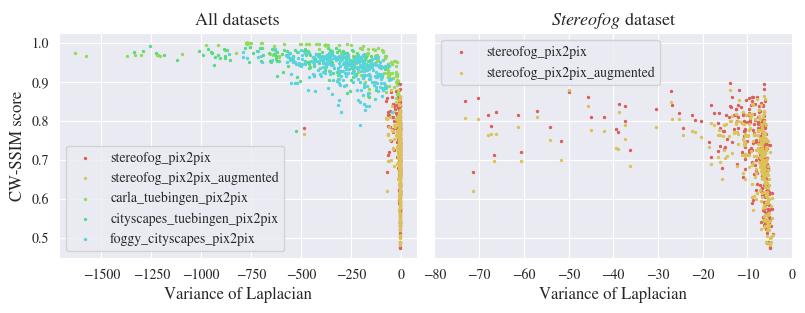

In [4]:
fig, ax = plt.subplots(1,2, figsize=set_size(fraction=1.5, subplots=(1,2)), sharey=True)

for i, results_path in enumerate(results_paths):
    ax[0].scatter(all_laplace_scores[i], all_CW_SSIM_scores[i], label=results_path.split('/')[-1], s=2)
    if 'synthetic' not in results_path:
        ax[1].scatter(all_laplace_scores[i], all_CW_SSIM_scores[i], label=results_path.split('/')[-1], s=2)

ax[0].legend()
ax[1].legend()
# ax[0].set_xlim(-1600)
ax[1].set_xlim(-80, 0)

ax[0].set_xlabel('Variance of Laplacian')
ax[1].set_xlabel('Variance of Laplacian')
ax[0].set_ylabel('CW-SSIM score')
# ax[1].set_ylabel('NCC score')

ax[0].set_title('All datasets')
ax[1].set_title('$Stereofog$ dataset')

# plt.suptitle('Laplacian score vs CW-SSIM score')

# plt.tight_layout()
plt.subplots_adjust(wspace=0.05)

plt.savefig('plots/laplace_vs_SSIM.pdf', format='pdf', bbox_inches='tight')